# 3.1 Deep Taylor Decomposition

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os
import re

from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_3_2 import MNIST_CNN, LRP

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/3_2_DTD/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('DTD', X)
    
    for activation in activations:
        tf.add_to_collection('DTD', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.161628492 accuracy = 0.949963643
Epoch: 0002 cost = 0.042360754 accuracy = 0.986545464
Epoch: 0003 cost = 0.028856052 accuracy = 0.990727281
Epoch: 0004 cost = 0.021793607 accuracy = 0.992818188
Epoch: 0005 cost = 0.017728731 accuracy = 0.993927278
Epoch: 0006 cost = 0.014391203 accuracy = 0.995290913
Epoch: 0007 cost = 0.011935470 accuracy = 0.996018185
Epoch: 0008 cost = 0.008921285 accuracy = 0.997145457
Epoch: 0009 cost = 0.010652733 accuracy = 0.996600003
Epoch: 0010 cost = 0.007860276 accuracy = 0.997272730
Epoch: 0011 cost = 0.008218002 accuracy = 0.997272730
Epoch: 0012 cost = 0.006254880 accuracy = 0.997981820
Epoch: 0013 cost = 0.007731757 accuracy = 0.997309093
Epoch: 0014 cost = 0.005743251 accuracy = 0.997927275
Epoch: 0015 cost = 0.004997690 accuracy = 0.998181820
Accuracy: 0.9852


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='CNN')

activations = tf.get_collection('DTD')
X = activations[0]

INFO:tensorflow:Restoring parameters from ./tf_logs/3_2_DTD/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [5]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

lrp = LRP(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'LRP')

Rs = []
for i in range(10):
    Rs.append(lrp(i))

### 6. Calculating Relevance Scores $R(x_i)$

In [6]:
images = mnist.train.images
labels = mnist.train.labels

sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

imgs = []
for i in range(10):
    imgs.append(sess.run(Rs[i], feed_dict={X: sample_imgs[i][None,:]}))

### 7. Displaying Images

The gradients are visualized as heat maps. You can see which features/data points influenced the DNN most its decision making.

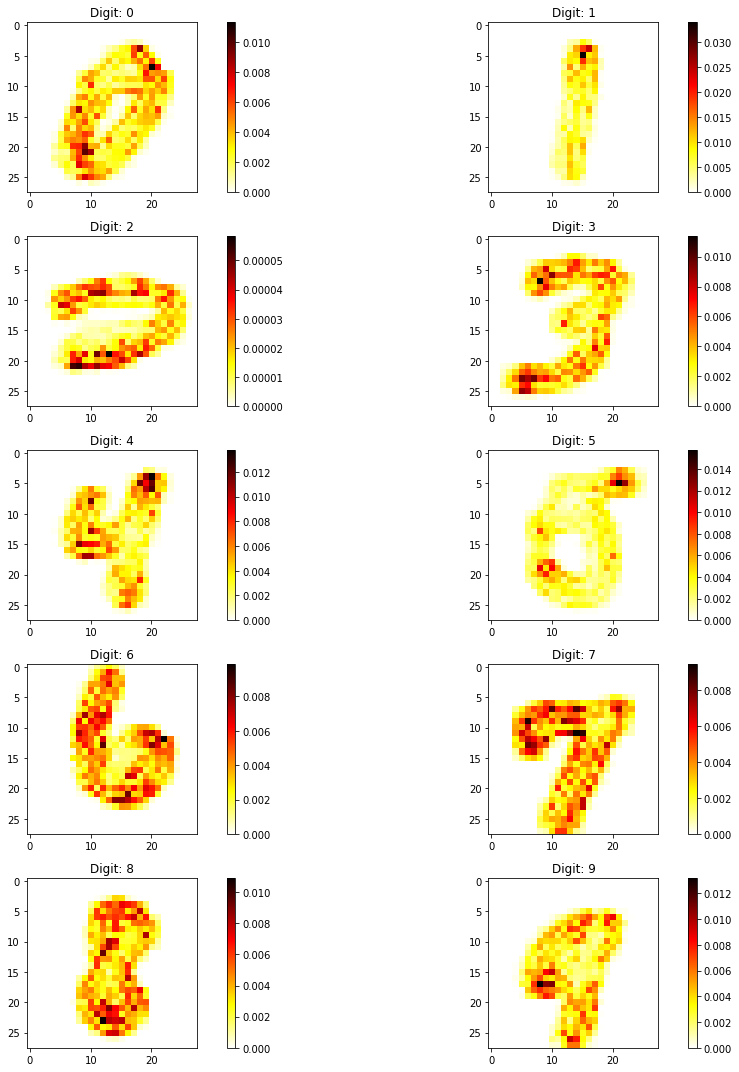

In [7]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(imgs[2 * i], [28, 28]), cmap='hot_r')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(imgs[2 * i + 1], [28, 28]), cmap='hot_r')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()